In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc

np.random.seed(0)

In [2]:
def generate_baskets(num_baskets, basket_sizes, catalog_size, distribution, skew_factor=1.9):
    baskets = []
    for i in range(num_baskets):
        if distribution == "normal":
            mean = catalog_size / 2  
            std_dev = catalog_size / 6  
            basket = np.clip(np.random.normal(mean, std_dev, int(basket_sizes[i])).astype(int), 0, catalog_size - 1)
            basket = np.unique(basket)  
            while len(basket) < basket_sizes[i]:  
                additional = np.clip(np.random.normal(mean, std_dev, int(basket_sizes[i])).astype(int), 0, catalog_size - 1)
                basket = np.unique(np.concatenate((basket, additional)))
            basket = basket[:int(basket_sizes[i])] 

        elif distribution == "uniform":
            basket = np.random.choice(range(catalog_size), int(basket_sizes[i]), replace=False)

        elif distribution == "skewed":
            prob = np.array([np.power(i + 1, -skew_factor) for i in range(catalog_size)])
            prob /= prob.sum()
            basket = np.random.choice(range(catalog_size), int(basket_sizes[i]), replace=False, p=prob)

        baskets.append(basket)

    return baskets

red_factor = 5
bsk_size = int(25/red_factor)
num_baskets = int(10000/red_factor)
catalog_size = int(1000/red_factor)
baskets_sizes = np.random.normal(bsk_size, bsk_size*0.1, num_baskets)

baskets_normal = generate_baskets(num_baskets, baskets_sizes, catalog_size, "normal")
baskets_uniform = generate_baskets(num_baskets, baskets_sizes, catalog_size, "uniform")
baskets_skewed = generate_baskets(num_baskets, baskets_sizes, catalog_size, "skewed")


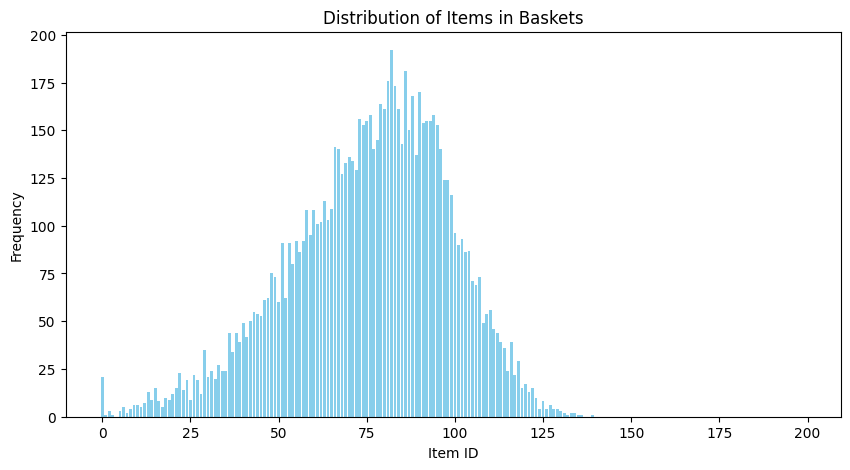

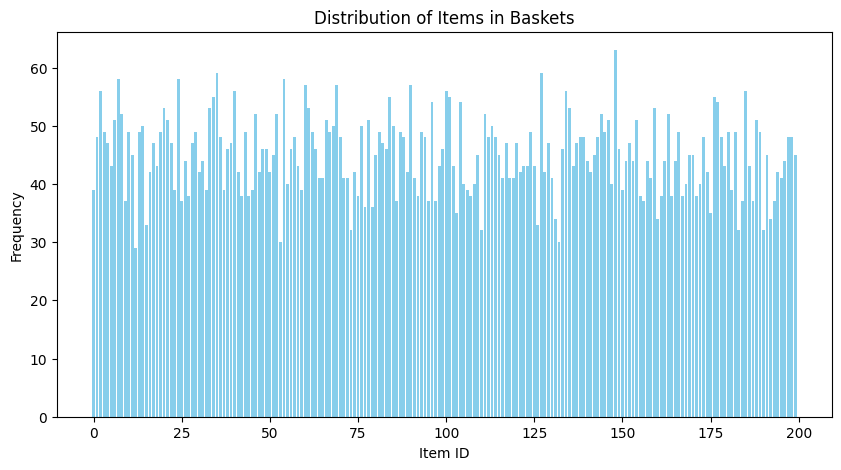

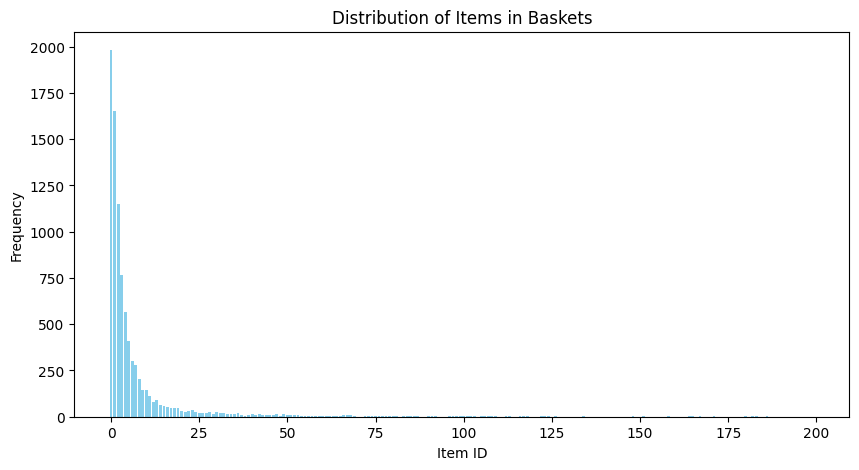

In [3]:
def plot_item_distribution(baskets, catalog_size):
    item_counts = np.zeros(catalog_size)
    for basket in baskets:
        for item in basket:
            item_counts[item] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(range(catalog_size), item_counts, color='skyblue')
    plt.xlabel("Item ID")
    plt.ylabel("Frequency")
    plt.title("Distribution of Items in Baskets")
    plt.show()

plot_item_distribution(baskets_normal, catalog_size=catalog_size)
plot_item_distribution(baskets_uniform, catalog_size=catalog_size)
plot_item_distribution(baskets_skewed, catalog_size=catalog_size)


Naive Algorithm

In [5]:
def naive_algorithm(data, support_threshold):
    tracemalloc.start()
    start_time = time.time()
    
    #PASS 1: count of every singletons
    singleton_counts = {}
    for transaction in data:
        for item in transaction:
            if item in singleton_counts:
                singleton_counts[item] += 1
            else:
                singleton_counts[item] = 1

    frequent_singletons = {item for item, count in singleton_counts.items() if count >= support_threshold}

    #PASS 2: count of every possibile pairs, regardless frequent singletons
    pair_counts = {}
    for transaction in data:
        for i in range(len(transaction)):
            for j in range(i + 1, len(transaction)):
                pair = frozenset([transaction[i], transaction[j]])
                if pair in pair_counts:
                    pair_counts[pair] += 1
                else:
                    pair_counts[pair] = 1

    frequent_pairs = {pair for pair, count in pair_counts.items() if count >= support_threshold}

    num_singletons = len(singleton_counts)
    num_pairs = len(pair_counts)
    num_frequent_pairs = len(frequent_pairs)
    
    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()
    tracemalloc.stop()

    return {
        'num_singletons': num_singletons,
        'num_pairs': num_pairs,
        'num_frequent_pairs': num_frequent_pairs,
        'execution_time': end_time - start_time,
        'memory_usage': peak
    }


A-Priori Algorithm

In [6]:
def apriori_algorithm(data, support_threshold):
    tracemalloc.start()
    start_time = time.time()

    #PASS 1: count of every singletons
    singleton_counts = {}
    for transaction in data:
        for item in transaction:
            if item in singleton_counts:
                singleton_counts[item] += 1
            else:
                singleton_counts[item] = 1

    frequent_singletons = {item for item, count in singleton_counts.items() if count >= support_threshold}

    #PASS 2: count of every possibile pairs obtained using only frequent singletons
    pair_counts = {}
    for transaction in data:
        filtered_transaction = [item for item in transaction if item in frequent_singletons]
        for i in range(len(filtered_transaction)):
            for j in range(i + 1, len(filtered_transaction)):
                pair = frozenset([filtered_transaction[i], filtered_transaction[j]])
                if pair in pair_counts:
                    pair_counts[pair] += 1
                else:
                    pair_counts[pair] = 1

    frequent_pairs = {pair for pair, count in pair_counts.items() if count >= support_threshold}

    num_singletons = len(frequent_singletons)
    num_pairs = len(pair_counts)
    num_frequent_pairs = len(frequent_pairs)
    
    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()
    tracemalloc.stop()

    return {
        'num_singletons': num_singletons,
        'num_pairs': num_pairs,
        'num_frequent_pairs': num_frequent_pairs,
        'execution_time': end_time - start_time,
        'memory_usage': peak
    }

PCY Algorithm

In [7]:
def pcy_algorithm(data, support_threshold, num_buckets=15000):
    tracemalloc.start()
    start_time = time.time()

    singleton_counts = {}
    bucket_counts = [0] * num_buckets

    # PASS 1: count of every singletons & hashing of the pairs to a bucket 
    for transaction in data:
        for item in transaction:

            # PASS 1A: counting singletons
            if item in singleton_counts:
                singleton_counts[item] += 1
            else:
                singleton_counts[item] = 1

        #PASS 1B: hashing pairs to a bucket
        for i in range(len(transaction)):
            for j in range(i + 1, len(transaction)):
                bucket = (transaction[i] * 10 + transaction[j]) % num_buckets
                bucket_counts[bucket] += 1

    frequent_singletons = {item for item, count in singleton_counts.items() if count >= support_threshold}
    
    frequent_buckets = {bucket for bucket, count in enumerate(bucket_counts) if count >= support_threshold}

    #PASS 2: count of frequent pairs

    # Necessary conditions: 1- i and j frequent items
    #                       2- (i,j) hashes to a bucket number whose bit is 1

    bitmap = [1 if bucket in frequent_buckets else 0 for bucket in range(num_buckets)]

    pair_counts = {}
    for transaction in data:
        filtered_transaction = [item for item in transaction if item in frequent_singletons]
        for i in range(len(filtered_transaction)):
            for j in range(i + 1, len(filtered_transaction)):
                bucket = (filtered_transaction[i] * 10 + filtered_transaction[j]) % num_buckets
                if bitmap[bucket] == 1:
                    pair = frozenset([filtered_transaction[i], filtered_transaction[j]])
                    pair_counts[pair] = pair_counts.get(pair, 0) + 1
                    
    frequent_pairs = {pair for pair, count in pair_counts.items() if count >= support_threshold}

    num_singletons = len(frequent_singletons)
    num_pairs = len(pair_counts)
    num_frequent_pairs = len(frequent_pairs)
    num_frequent_buckets = len(frequent_buckets)

    current, peak = tracemalloc.get_traced_memory()
    end_time = time.time()
    tracemalloc.stop()

    return {
        'num_singletons': num_singletons,
        'num_pairs': num_pairs,
        'num_frequent_pairs': num_frequent_pairs,
        'num_frequent_buckets': num_frequent_buckets,
        'execution_time': end_time - start_time,
        'memory_usage': peak
    }

In [8]:
def measure_performance(algo, baskets, min_support):
    result = algo(baskets, min_support)
    time_taken = result['execution_time']
    memory_usage_kb = result['memory_usage'] / 1024
    num_singletons = result.get('num_singletons', 0)
    num_pairs = result.get('num_pairs', 0)
    num_frequent_pairs = result.get('num_frequent_pairs', 0)
    num_frequent_buckets = result.get('num_frequent_buckets', 0)

    return time_taken, memory_usage_kb, num_singletons, num_pairs, num_frequent_pairs, num_frequent_buckets

In [9]:
def run_experiment(catalog_size, alpha=0.5):
    distributions = ["normal", "uniform", "skewed"]
    algorithms = [("Naive", naive_algorithm), ("Apriori", apriori_algorithm), ("PCY", pcy_algorithm)]
    num_baskets = 10000
    bsk_size = 30
    baskets_sizes = np.random.normal(bsk_size, bsk_size*0.1, num_baskets)
    min_support = (bsk_size/catalog_size) * num_baskets * alpha
    
    results = []
    
    print(f"Catalog Size: {catalog_size}")
    print(f"Support: {min_support}")
    print("#" * 60)
    for distribution in distributions:
        print()
        print("Distribution:", distribution.capitalize())
        print()
        baskets = generate_baskets(num_baskets, baskets_sizes, catalog_size, distribution)
        
        for algo_name, algo in algorithms:
            print()
            print(f"{algo_name}")
            print("-" * 60)
            
            time_taken, memory_usage, num_singletons, num_pairs, num_frequent_pairs, num_frequent_buckets = measure_performance(algo, baskets, min_support)
            
            results.append((algo_name, catalog_size, distribution, time_taken, memory_usage, num_singletons, num_pairs, num_frequent_pairs, num_frequent_buckets))
            
            print(f"Time: {time_taken:.4f}s, Memory Usage: {memory_usage:.2f} KB")
            print(f"Singletons: {num_singletons}, Candidate Pairs: {num_pairs}, Frequent Pairs: {num_frequent_pairs}")
            if algo_name == "PCY":
                print(f"Frequent Buckets: {num_frequent_buckets}")
            print("-" * 60)
        print("#" * 60)

    return results


In [10]:
results1 = run_experiment(500, 0.075)

Catalog Size: 500
Support: 45.0
############################################################

Distribution: Normal


Naive
------------------------------------------------------------
Time: 18.9668s, Memory Usage: 15157.48 KB
Singletons: 310, Candidate Pairs: 43063, Frequent Pairs: 19823
------------------------------------------------------------

Apriori
------------------------------------------------------------
Time: 16.1506s, Memory Usage: 12817.54 KB
Singletons: 284, Candidate Pairs: 39140, Frequent Pairs: 19823
------------------------------------------------------------

PCY
------------------------------------------------------------
Time: 58.8553s, Memory Usage: 13284.68 KB
Singletons: 284, Candidate Pairs: 38923, Frequent Pairs: 19823
Frequent Buckets: 2933
------------------------------------------------------------
############################################################

Distribution: Uniform


Naive
------------------------------------------------------------
Time: 

In [11]:
results2 = run_experiment(500, 0.91)

Catalog Size: 500
Support: 546.0
############################################################

Distribution: Normal


Naive
------------------------------------------------------------
Time: 19.1330s, Memory Usage: 12648.80 KB
Singletons: 310, Candidate Pairs: 43220, Frequent Pairs: 191
------------------------------------------------------------

Apriori
------------------------------------------------------------
Time: 10.9032s, Memory Usage: 4099.76 KB
Singletons: 174, Candidate Pairs: 15051, Frequent Pairs: 191
------------------------------------------------------------

PCY
------------------------------------------------------------
Time: 48.6939s, Memory Usage: 4515.07 KB
Singletons: 174, Candidate Pairs: 14692, Frequent Pairs: 191
Frequent Buckets: 2026
------------------------------------------------------------
############################################################

Distribution: Uniform


Naive
------------------------------------------------------------
Time: 21.2425